# Linear Regression for Student's Grade dataset


In [15]:
#importing all the necessary libraries
from __future__ import division
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # data visualization library
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score



from sklearn.model_selection import cross_val_score


%matplotlib inline


In [69]:
#Load dataset from csv file, here only Math scores data is used

student_df = pd.read_csv('student-mat.csv', sep=';')
print(student_df.head())
print(student_df.info())
print(student_df.describe())

#Dataset has 395 rows and 33 columns, where 'G3' is our target variable

  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob ...  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher ...   
1     GP   F   17       U     GT3       T     1     1  at_home     other ...   
2     GP   F   15       U     LE3       T     1     1  at_home     other ...   
3     GP   F   15       U     GT3       T     4     2   health  services ...   
4     GP   F   16       U     GT3       T     3     3    other     other ...   

  famrel freetime  goout  Dalc  Walc health absences  G1  G2  G3  
0      4        3      4     1     1      3        6   5   6   6  
1      5        3      3     1     1      3        4   5   5   6  
2      4        3      2     2     3      3       10   7   8  10  
3      3        2      2     1     1      5        2  15  14  15  
4      4        3      2     1     2      5        4   6  10  10  

[5 rows x 33 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33

count    395.000000
mean      10.415190
std        4.581443
min        0.000000
25%        8.000000
50%       11.000000
75%       14.000000
max       20.000000
Name: G3, dtype: float64


count    357.000000
mean      11.523810
std        3.227797
min        4.000000
25%        9.000000
50%       11.000000
75%       14.000000
max       20.000000
Name: G3, dtype: float64

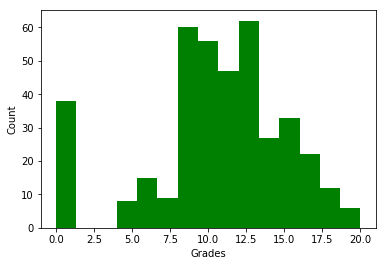

In [70]:
print(student_df.G3.describe())

plt.hist(student_df['G3'], color='green', bins=15)
plt.xlabel('Grades')
plt.ylabel('Count')

#On the plot we can see that there might be some outliers at 0 or 1
#Let's check it out

student_df['G3'].value_counts()

# So here's 38 'zero' values in our target variable. let's remove it first, later we can check 
#these values have an serious affect on our model:
student_df = student_df[~student_df['G3'].isin([0,1])]
student_df['G3'].describe()

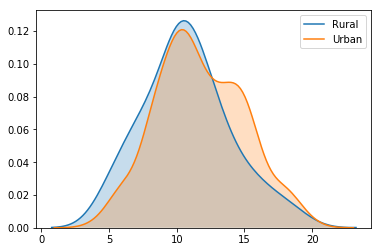

In [71]:
# Distribution looks really close to normal with mode in 11 with no noticable skew.
#Let's check how catigoracal variables influence on the Grade.

#What effect 'address' or area has on the Grade?
sns.kdeplot(student_df.loc[student_df['address'] == 'R','G3'], label = 'Rural', shade=True)
sns.kdeplot(student_df.loc[student_df['address'] == 'U', 'G3'], label = 'Urban', shade=True)



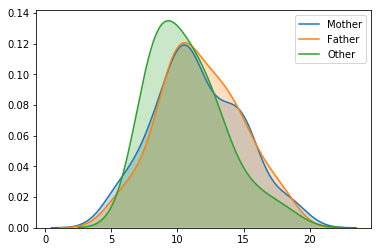

In [72]:
#What about a guardian?

sns.kdeplot(student_df.loc[student_df['guardian'] == 'mother','G3'], label = 'Mother', shade=True)
sns.kdeplot(student_df.loc[student_df['guardian'] == 'father','G3'], label = 'Father', shade=True)
sns.kdeplot(student_df.loc[student_df['guardian'] == 'other','G3'], label = 'Other', shade=True)

#It seems that there's no sagnificant influence fom both features.
#Let's prove it with some statistics

In [73]:
#Chick the correlations
print(student_df1.corr()['G3'].sort_values())

#As was expected, 'G2' and 'G3' have the most sagnificant effect on 'G3'. 
#Also Mother education 'Medu' and Father education 'Fedu' might affect out final grades.

failures     -0.360415
age          -0.161579
goout        -0.132791
traveltime   -0.117142
health       -0.061335
Dalc         -0.054660
Walc         -0.051939
freetime      0.011307
absences      0.034247
famrel        0.051363
studytime     0.097820
Fedu          0.152457
Medu          0.217147
G1            0.801468
G2            0.904868
G3            1.000000
Name: G3, dtype: float64


In [74]:
#Create the target variable for the further model training
y = student_df['G3']

# student_df =  student_df.drop(columns = ['G1', 'G2'])
#As sklearn works only with numerical data, let's do some oe-hot encoding for our catigorical variables
student_df = pd.get_dummies(student_df, drop_first=True)

#Get 6 features with highest level of correlation with 'G3'
max_corr = student_df.corr().abs()['G3'].sort_values(ascending=False).drop_duplicates()[:7]

#Create the features dataframe
x = student_df.loc[:, max_corr.index]
x = x.drop(columns = 'G3')



In [78]:
#Linear Regression
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size= 0.25, random_state=42)

lin_model = LinearRegression()
lin_model.fit(x_train, y_train)

#Check the Mean Absolute Error and Roor Mean Squared Error
mae = np.mean(abs(lin_model.predict(x_test)-y_test))
rmse = np.sqrt(np.mean((lin_model.predict(x_test) - y_test) ** 2))

print('Mean absolute error is %f' %(mae))
print('Root Mean squared error is %f' %rmse)
print(lin_model.score(x_test, y_test))
final_formula = 'Grade = %0.2f+'%lin_model.intercept_
for i, col in enumerate(x_train.columns):
    final_formula+='%0.3f * %s + '%(lin_model.coef_[i], col)
print(final_formula[:-2])


Mean absolute error is 0.627402
Root Mean squared error is 0.829924
0.928623540750542
Grade = 0.32+0.864 * G2 + 0.129 * G1 + -0.004 * failures + -0.073 * schoolsup_yes + -0.009 * absences + -0.002 * Medu 


In [79]:
#As a result our Linear model shows rather good results,
#but it's obvious that's final grade  - 'G3' is affected by 'G1' and 'G2'. 
#So our goal -  to predict student's grades by their personal characteristics is not achived.
#Let's try to remove these 2 features from our dataset.

student_df = pd.read_csv('student-mat.csv', sep=';')

student_df =  student_df.drop(columns = ['G1', 'G2'])
student_df = pd.get_dummies(student_df, drop_first=True)

#Get 6 features with highest level of correlation with 'G3'
max_corr = student_df.corr().abs()['G3'].sort_values(ascending=False).drop_duplicates()[:7]

#Create the features dataframe
x = student_df.loc[:, max_corr.index]
x = x.drop(columns = 'G3')

y = student_df['G3']




In [81]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size= 0.25, random_state=42)

lin_model = LinearRegression()
lin_model.fit(x_train, y_train)

#Check the Mean Absolute Error and Roor Mean Squared Error
mae = np.mean(abs(lin_model.predict(x_test)-y_test))
rmse = np.sqrt(np.mean((lin_model.predict(x_test) - y_test) ** 2))

print('Mean absolute error is %f' %(mae))
print('Root Mean squared error is %f' %rmse)
print(lin_model.score(x_test, y_test))
final_formula = 'Grade = %0.2f+'%lin_model.intercept_
for i, col in enumerate(x_train.columns):
    final_formula+='%0.3f * %s + '%(lin_model.coef_[i], col)
print(final_formula[:-2])



Mean absolute error is 3.555774
Root Mean squared error is 4.493144
0.12368836378451796
Grade = 12.17+-1.778 * failures + 0.724 * Medu + 2.126 * higher_yes + -0.151 * age + -0.536 * Fedu + -0.400 * goout 


In [82]:
#Define function that will plot CV scores vs 'alpha' parameter in Ridge and Lasso Regularization
def display_plot(cv_scores, cv_scores_std, cv_scores1, cv_scores_std1):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.plot(alpha_space, cv_scores, color='blue')
    ax.plot(alpha_space, cv_scores1, color='red')


    std_error = cv_scores_std / np.sqrt(10)
    std_error1 = cv_scores_std1 / np.sqrt(10)


    ax.fill_between(alpha_space, cv_scores + std_error, cv_scores - std_error, alpha=0.2)
    ax.fill_between(alpha_space, cv_scores1 + std_error1, cv_scores1 - std_error1, alpha=0.2)


    ax.set_ylabel('CV Score +/- Std Error')
    ax.set_xlabel('Alpha')
    ax.axhline(np.max(cv_scores), linestyle='--', color='.5')
    ax.set_xlim([alpha_space[0], alpha_space[-1]])
    ax.set_xscale('log')
    plt.show()

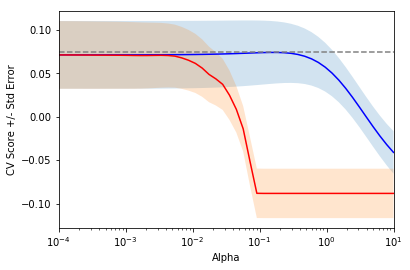

In [83]:
alpha_space = np.logspace(-4, 1, 50)
ridge_scores = []
lasso_scores = []
ridge_scores_std = []
lasso_scores_std = []

# Create a ridge regressor: ridge
ridge = Ridge(normalize=True)
lasso = Lasso(normalize=True)
# Compute scores over range of alphas
for alpha in alpha_space:

    # Specify the alpha value to use: ridge.alpha
    ridge.alpha = alpha
    lasso.alpha = alpha
    
    # Perform 10-fold CV: ridge_cv_scores
    ridge_cv_scores = cross_val_score(ridge, x, y, cv=10)
    lasso_cv_scores = cross_val_score(lasso, x, y, cv=10)
    
    # Append the mean of ridge_cv_scores to ridge_scores
    ridge_scores.append(np.mean(ridge_cv_scores))
    lasso_scores.append(np.mean(lasso_cv_scores))
    
    # Append the std of ridge_cv_scores to ridge_scores_std
    ridge_scores_std.append(np.std(ridge_cv_scores))
    lasso_scores_std.append(np.std(lasso_cv_scores))

# Display the plot
display_plot(ridge_scores, ridge_scores_std, lasso_scores, lasso_scores_std)